# The Simulator Class

The most convenient way to use ``hera_sim`` is to use the ``Simulator`` class, which builds in all the primary functionality of the ``hera_sim`` package in an easy-to-use interface, and adds the ability to consistently write all produced effects into a ``pyuvdata.UVData`` object (and to file).

What follows is a quick tour of the main functionality this provides.

## Setup

In [1]:
from hera_sim.simulate import Simulator

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import uvtools

from hera_sim.noise import HERA_Tsky_mdl

## The Simulator Class

The ``Simulator`` class holds everything required to generate and do basic analysis on a simulation. It can be instantiated either by submitting a filename pointing to an existing  simulation (in uvfits, uvh5 or miriad format), *or* a set of keyword arguments which are passed to the ``hera_sim.io.empty_uvdata`` function. The following are all the required arguments, plus an argument to set the total time of the observation to about 12 hours:

In [2]:
sim = Simulator(
    n_freq = 1024,
    n_times = 1000,
    antennas = {
        0: (20.0, 20.0, 0),
        1: (50.0, 50.0, 0)
    },
    antpairs = "cross",   # model only one baseline
    time_per_integ=86164.1/12/1000, # roughly 12 hours of total time
)

Note that you don't _need_ to pass ``antpairs``. By default it will use all pairs of antennas (but not the conjugates). You can specify exact pairs to use as a list of tuples, or use a number of default presets, such as "EW" for only East-West aligned baselines, or "redundant" for redundant baseline _groups_.

We'll use a standard waterfall plot throughout the notebook to show the progress of the simulation:

In [3]:
def waterfall(
    vis, freq=sim.data.freq_array[0]/1e6, lsts=sim.data.lst_array, 
    vmax=None, vrange = None, 
):
    """
    A wrapper around the uvtools' waterfall function providing some
    extra labelling and plot adjustment.
    """
    fig, ax = plt.subplots(
        2,1, sharex=True, sharey=True, figsize=(11,6)
    )
    
    plt.sca(ax[0])
    uvtools.plot.waterfall(
        vis[:,0,:,0], mode='log', mx=vmax, drng=vrange,
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar()
    plt.ylabel("LST", fontsize=15)
    
    plt.sca(ax[1])
    uvtools.plot.waterfall(
        vis[:,0,:,0], 
        mode='phs',
        extent=(freq.min(), freq.max(), lsts.min(), lsts.max())
    )
    plt.colorbar()
    plt.xlabel("Frequency [MHz]", fontsize=15)
    plt.ylabel("LST", fontsize=15)
    

This will instantiate a ``UVData`` object, which can be accessed via the ``data`` attribute of the object. Thus for example:

In [4]:
sim.data.history

'Generated by hera_sim'

In [5]:
sim.antpos

{0: array([11.31077518, 13.24381279, 22.28604468]),
 1: array([28.27693796, 33.10953197, 55.71511171])}

## Adding Effects

All simulated effects offered by the ``Simulator`` class are defined as methods beginning with ``add_``. Most of these methods have as their first parameter a *model*, which defines which model of the particular component to add. For example, the ``add_foregrounds`` method can accept ``"diffuse_foreground"`` or ``"pntsrc_foreground"``. These can be passed as strings or callable functions. 

Also, all ``add_xxx`` models have the option to _not_ add their calculated visibilities to the data, and also the ability to return just visibilities from that particular model. We will show a couple of these examples in the following, but note that this keywords apply to _all_ models.

### Foregrounds

In [6]:
sim.add_foregrounds(
    "diffuse_foreground",
    Tsky = HERA_Tsky_mdl['xx']
)

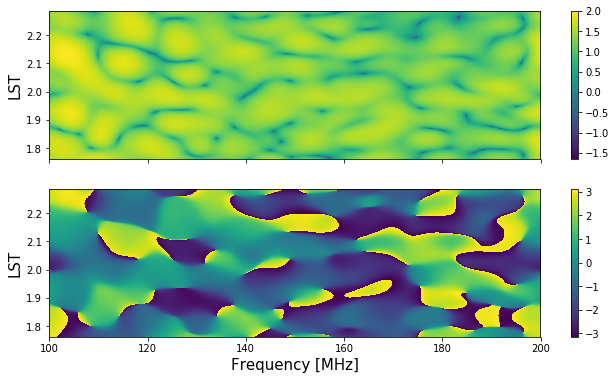

In [7]:
waterfall(sim.data.data_array)

In [8]:
sim.add_foregrounds(
    "pntsrc_foreground",
    nsrcs = 5000
)

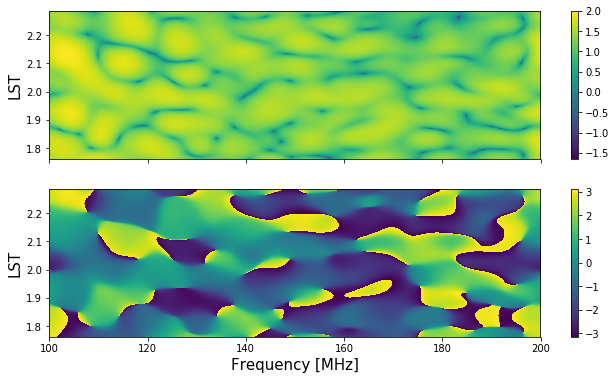

In [9]:
waterfall(sim.data.data_array)

### EoR

In this case, we'll use a pre-defined function, instead of the string. 

Also, instead of adding the visibilities to the data, let's just return the visibilities so that we can see the purely EoR waterfall:

In [10]:
from hera_sim import eor

eor_vis = sim.add_eor(
    model=eor.noiselike_eor,
    add_vis = False
)

divide by zero encountered in log10


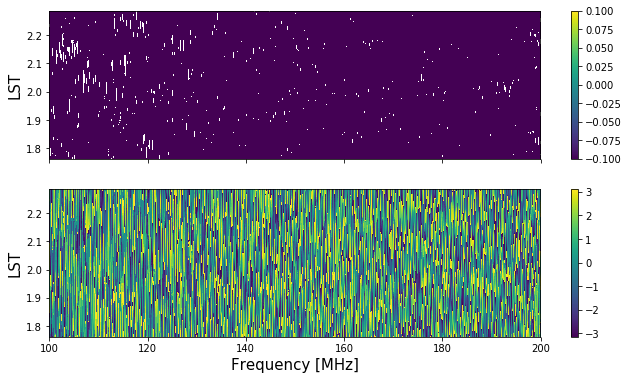

In [11]:
waterfall(eor_vis)

If we had wanted to _both_ return the visibilities, _and_ add them to the underlying data:

In [12]:
eor_vis = sim.add_eor(
    model=eor.noiselike_eor,
    ret_vis = True
)

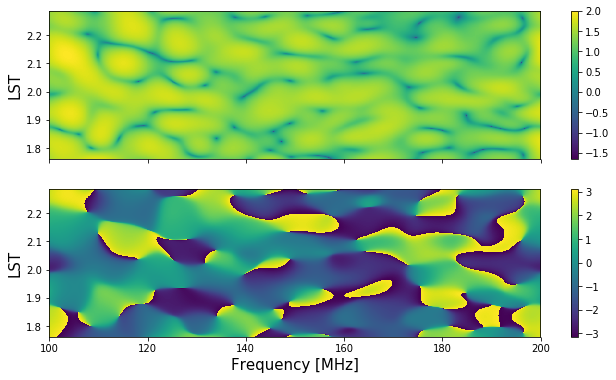

In [13]:
waterfall(sim.data.data_array)

### Noise

In [14]:
sim.add_noise(
    "thermal_noise",
    Tsky_mdl = HERA_Tsky_mdl['xx'],
    Trx = 150.0
)

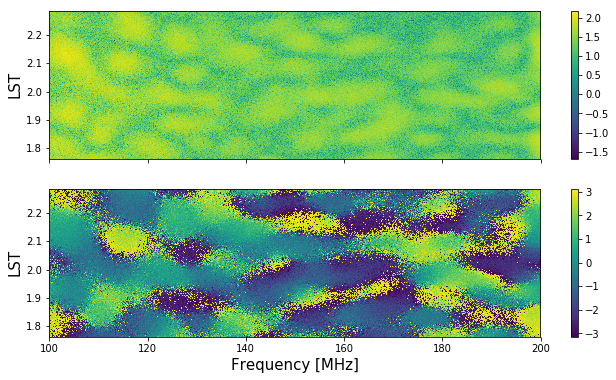

In [15]:
waterfall(sim.data.data_array)

### RFI

In [16]:
sim.add_rfi(
    "rfi_stations",
)

sim.add_rfi(
    "rfi_impulse",
    chance=0.01,
    strength=100.0
)

sim.add_rfi(
    "rfi_scatter",
    chance=0.001, 
    strength=20,
    std = 5
)

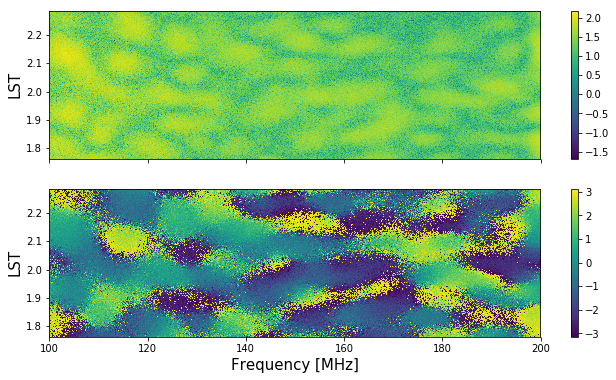

In [17]:
waterfall(sim.data.data_array)

### Gains

In [18]:
sim.add_gains()

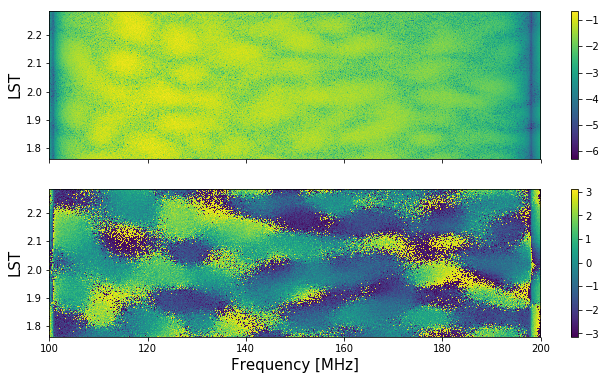

In [19]:
waterfall(sim.data.data_array)

### Reflections

In this case, let's define our own function to add reflections.

In [20]:
def my_reflections(vis, freqs, amp, dly, phs, index = 1, conj=False):
    """
    Just like the built-in auto_reflection, but with the option
    to raise the reflections to a power...
    """
    # form reflection coefficient
    eps = amp * np.exp(2j * np.pi * freqs * dly + 1j * phs)
    if conj:
        eps = eps.conj()

    # multiply into data
    out_vis = vis * (1 + eps)**index

    return out_vis

In [21]:
sim.add_auto_reflections(
    my_reflections,
    amp=1.0,
    dly=10.0,
    phs=1.0
)

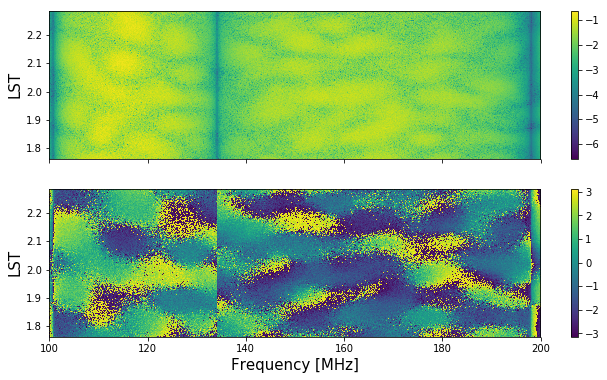

In [22]:
waterfall(sim.data.data_array)

### Crosstalk

In [23]:
sim.add_xtalk(
    amplitude=0.001
)

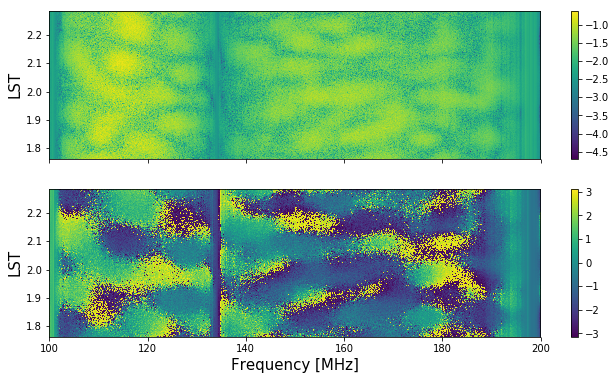

In [24]:
waterfall(sim.data.data_array)

## Ordering of Effects

Some of the effects that can be modeled in ``hera_sim`` act on the pre-existing visibilities (usually multiplicatively). An example of this is are the gains. The gains multiply the existing absolute visibilities. Thus these should never be added _before_ adding an absolute effect. ``hera_sim`` will not stop you from doing so, but will issue a warning. For instance, now that we have already added some relative effects, let's try adding another absolute effect:

In [25]:
sim.add_eor("noiselike_eor")

You are adding absolute visibilities _after_ determining visibilities that should depend on these. Please re-consider.


## Inspecting the results

Each modelling component automatically adds itself to the ``UVData`` object's history, which can be inspected:

In [27]:
print(sim.data.history)

Generated by hera_sim
hera_sim v0.0.1: Added foregrounds using diffuse_foreground with kwargs: {'Tsky': <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x7f0a370b1fd0>}
hera_sim v0.0.1: Added foregrounds using pntsrc_foreground with kwargs: {'nsrcs': 5000}
hera_sim v0.0.1: Added eor using noiselike_eor with kwargs: {}
hera_sim v0.0.1: Added noise using thermal_noise with kwargs: {'Trx': 150.0, 'Tsky_mdl': <scipy.interpolate.fitpack2.RectBivariateSpline object at 0x7f0a370b1fd0>}
hera_sim v0.0.1: Added rfi using rfi_stations with kwargs: {}
hera_sim v0.0.1: Added rfi using rfi_impulse with kwargs: {'chance': 0.01, 'strength': 100.0}
hera_sim v0.0.1: Added rfi using rfi_scatter with kwargs: {'std': 5, 'chance': 0.001, 'strength': 20}
hera_sim v0.0.1: Added gains with kwargs: {}
hera_sim v0.0.1: Added autoreflections using my_reflections with kwargs: {'phs': 1.0, 'amp': 1.0, 'dly': 10.0}
hera_sim v0.0.1: Added xtalk with kwargs: {'amplitude': 0.001}
hera_sim v0.0.1: Added eor us

The simulation can be also written to file:

In [29]:
sim.write_data("hera_simulation.uvh5")